Dataset from: https://www.kaggle.com/datasets/techsash/waste-classification-data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np 
import pandas as pd 
import os
import shutil
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tensorflow.keras import optimizers, Model, layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import ModelCheckpoint

from PIL import Image

In [3]:
data_path = '/content/drive/MyDrive/Waste_Segregation_Project/DATASET'
folder_path = '/content/drive/MyDrive/Waste_Segregation_Project'
save_model_path = '/content/drive/MyDrive/Waste_Segregation_Project/saved_models/'
visualisation_path = '/content/drive/MyDrive/Waste_Segregation_Project/visualisations/'

In [4]:
if not os.path.exists(save_model_path):  # Creating the directory if it does not exist
    os.makedirs(save_model_path)

if not os.path.exists(visualisation_path):  # Creating the directory if it does not exist
    os.makedirs(visualisation_path)

In [5]:
IMAGE_SIZE = (224, 224, 3)
BATCH_SIZE = 32

# Unzipping Images

In [8]:
shutil.unpack_archive("/content/drive/MyDrive/Waste_Segregation_Project/archive.zip",
                      '/content/drive/MyDrive/Waste_Segregation_Project/')

In [9]:
train_O_images_len = len(os.listdir('/content/drive/MyDrive/Waste_Segregation_Project/DATASET/TRAIN/O'))
train_R_images_len = len(os.listdir('/content/drive/MyDrive/Waste_Segregation_Project/DATASET/TRAIN/R'))

valid_O_images_len = len(os.listdir('/content/drive/MyDrive/Waste_Segregation_Project/DATASET/TEST/O'))
valid_R_images_len = len(os.listdir('/content/drive/MyDrive/Waste_Segregation_Project/DATASET/TEST/R'))

train_images_len = train_O_images_len + train_R_images_len
valid_images_len = valid_O_images_len + valid_R_images_len

In [10]:
print('train_O_images_len: ', train_O_images_len)
print('train_R_images_len: ', train_R_images_len)
print("Total images in TRAIN directory:", train_images_len)

print('\nvalid_O_images_len: ', valid_O_images_len)
print('valid_R_images_len: ', valid_R_images_len)
print("Total images in VALIDATION directory:", valid_images_len)

train_O_images_len:  12565
train_R_images_len:  9999
Total images in TRAIN directory: 22564

valid_O_images_len:  1401
valid_R_images_len:  1112
Total images in VALIDATION directory: 2513


In [11]:
glob('/content/drive/MyDrive/Waste_Segregation_Project/DATASET/*/*/')

['DATASET/TEST/O/', 'DATASET/TEST/R/', 'DATASET/TRAIN/O/', 'DATASET/TRAIN/R/']

# Augmentation using ImageDataGenerator

In [12]:
train_datagen_aug = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen_aug = ImageDataGenerator(rescale = 1./255)

# Creating training and validation datasets

In [13]:
training_set = train_datagen_aug.flow_from_directory('/content/drive/MyDrive/Waste_Segregation_Project/DATASET/TRAIN',
                                                 target_size = (224, 224),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

validation_set = validation_datagen_aug.flow_from_directory('/content/drive/MyDrive/Waste_Segregation_Project/DATASET/TEST',
                                                  target_size = (224, 224),
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'categorical')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


# Creating Model Checkpoints

In [14]:
model_checkpoint_callback = ModelCheckpoint(filepath=os.path.join(save_model_path, 
                                                   "modelv001-{epoch:02d}.h5"), 
                                            save_best_only=True,
                                            save_weights_only=False,
                                            monitor='val_accuracy',
                                            mode='max') 

# ResNet Model

In [15]:
# load the ResNet network
base_model = ResNet50(weights = "imagenet", 
                      include_top = False,
                      input_tensor = Input(IMAGE_SIZE))

94781440/94765736 [==============================] - 0s 0us/step


In [16]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [17]:
# construct the head of the model that will be placed on top of the
# the base model

last_layer = base_model.layers[-1]
print('last layer output shape: ', last_layer.output_shape)

head_model = last_layer.output
head_model = layers.Flatten()(head_model)
head_model = layers.Dense(2, activation = "softmax")(head_model) # 2 classes, namely Organic (O) and Recyclable (R)

last layer output shape:  (None, 7, 7, 2048)


In [18]:
# place the head model on top of the base model
final_model = Model(inputs = base_model.input, outputs = head_model)

In [19]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in base_model.layers:
    layer.trainable = False

In [20]:
# compile our model
print("[INFO] compiling model...")

final_model.compile(loss = "categorical_crossentropy", 
                    optimizer='adam',
                    metrics = ["accuracy"])

print("\n\n[INFO] model compilation complete!")

[INFO] compiling model...


[INFO] model compilation complete!


In [21]:
# train the head of the network
print("[INFO] model training - epochs and summary...\n\n")

final_model_history = final_model.fit_generator(training_set,
                                                validation_data = validation_set,
                                                epochs = 20,
                                                steps_per_epoch = len(training_set) // BATCH_SIZE,
                                                validation_steps = len(validation_set) // BATCH_SIZE,
                                                callbacks=[model_checkpoint_callback])

print("\n\n[INFO] model training complete!\n\n")

[INFO] model training - epochs and summary...




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/20
22/22 [==============================] - 26s 519ms/step - loss: 2.9021 - accuracy: 0.5625 - val_loss: 1.1878 - val_accuracy: 0.5781
Epoch 2/20
22/22 [==============================] - 11s 506ms/step - loss: 1.3801 - accuracy: 0.6278 - val_loss: 0.7858 - val_accuracy: 0.6875
Epoch 3/20
22/22 [==============================] - 11s 484ms/step - loss: 0.7787 - accuracy: 0.6662 - val_loss: 0.7304 - val_accuracy: 0.7344
Epoch 4/20
22/22 [==============================] - 11s 489ms/step - loss: 0.6669 - accuracy: 0.6634 - val_loss: 0.6164 - val_accuracy: 0.7656
Epoch 5/20
22/22 [==============================] - 10s 462ms/step - loss: 0.7996 - accuracy: 0.6179 - val_loss: 1.6682 - val_accuracy: 0.4844
Epoch 6/20
22/22 [==============================] - 11s 521ms/step - loss: 0.8389 - accuracy: 0.6662 - val_loss: 0.5089 - val_accuracy: 0.7969
Epoch 7/20
22/22 [==============================] - 13s 573ms/step - loss: 0.7604 - accuracy: 0.6960 - val_loss: 0.6781 - val_accuracy: 0.7500

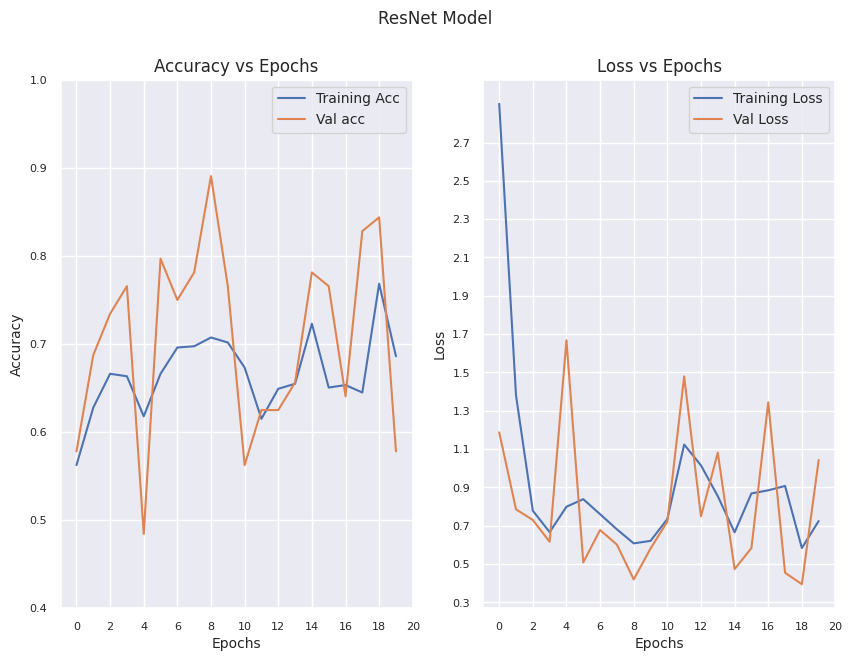

In [22]:
# Plots of Accuracy and Loss vs Epochs.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), dpi=100)


fig.suptitle("ResNet Model", fontdict = {'size': 10, 'weight' : 3})

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(final_model_history.history['accuracy'], label='Training Acc')
ax[0].plot(final_model_history.history['val_accuracy'], label='Val acc')
ax[0].set_xlabel('Epochs', fontsize=10)
ax[0].set_ylabel('Accuracy', fontsize=10)
ax[0].legend(fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].xaxis.set_ticks(np.arange(0, 21, 2))
ax[0].yaxis.set_ticks(np.arange(0.4, 1.05, 0.1))

ax[1].set_title('Loss vs Epochs')
ax[1].plot(final_model_history.history['loss'], label='Training Loss')
ax[1].plot(final_model_history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epochs', fontsize=10)
ax[1].set_ylabel('Loss', fontsize=10)
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].xaxis.set_ticks(np.arange(0, 21, 2))
ax[1].yaxis.set_ticks(np.arange(0.3, 2.8, 0.2))

fig.savefig(os.path.join(visualisation_path, 
                         'v001_resnet.png'), 
            dpi=300, 
            bbox_inches='tight')

plt.show()

In [23]:
resnet_history = pd.DataFrame(final_model_history.history)
resnet_history.head(20)

,loss,accuracy,val_loss,val_accuracy
0,2.902090,0.562500,1.187787,0.578125
1,1.380076,0.627841,0.785758,0.687500
2,0.778660,0.666193,0.730376,0.734375
3,0.666934,0.663352,0.616445,0.765625
4,0.799565,0.617898,1.668171,0.484375
5,0.838919,0.666193,0.508897,0.796875
6,0.760404,0.696023,0.678090,0.750000
7,0.681524,0.697443,0.601871,0.781250
8,0.608222,0.707386,0.420081,0.890625
9,0.621208,0.701705,0.581378,0.765625


In [24]:
resnet_history.to_csv(os.path.join(save_model_path, 
                                   'resnet_history.csv'),
                      index=False)

# Predicting on test images

Actual Category: O
Predicted Category: O


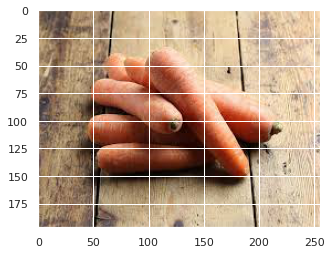

In [26]:
# Test your model performance on custom data
categories = ['R', 'O']

im1 = Image.open("/content/drive/MyDrive/Waste_Segregation_Project/DATASET/TEST/O/O_12577.jpg")
plt.imshow(im1)
print("Actual Category: O")

# Pre-processing the image

im1 = im1.resize((224,224))
im1 = np.expand_dims(im1, axis=0)
im1 = np.array(im1)
im1 = im1/255

# Predicting using the model

pred1 = final_model.predict([im1])[0]
pred1 = np.argmax(pred1)
print("Predicted Category:", categories[pred1])

Actual Category: R
Predicted Category: R


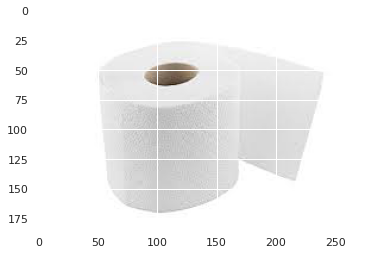

In [27]:
# Test your model performance on custom data
categories = ['O', 'R']

im1 = Image.open("DATASET/TEST/R/R_11107.jpg")
plt.imshow(im1)
print("Actual Category: R")

im1 = im1.resize((224,224))
im1 = np.expand_dims(im1, axis=0)
im1 = np.array(im1)
im1 = im1/255
pred1 = final_model.predict([im1])[0]
pred1 = np.argmax(pred1)
# print(pred1)
print("Predicted Category:", categories[pred1])